# Pokemon Classifier
Made with Fast AI

In [1]:
from fastai.vision.all import *
import nbdev

In [2]:
doc(RandomResizedCrop)

In [3]:
path = Path('.').cwd()/'PokemonData'
path

Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData')

In [4]:
images = get_image_files(path)
images

(#6820) [Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/894adfbb050b4ae28914e18327fee4a4.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/4e3758843ef84f79be49d37d42291ed3.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/c79e64fe6b2647d6a34537536f7487bf.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/564a1c4959974f36b5a25610f7e81f42.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/8be42e059bda4a75bf549a2d08804cdc.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/16c3a65771044f689656e16e0c56f1c0.jpg'),Path('/home/agastya/notebooks/FastAI-course/self-implementation/03-pokemon-classifier/PokemonData/Ponyta/07ea12cb6f2d4236892737

In [5]:
failed = verify_images(images)

In [6]:
failed.map(Path.unlink)

(#0) []

In [7]:
pokemon = DataBlock(blocks = (ImageBlock,CategoryBlock),
                    get_items = get_image_files,
                    get_y = parent_label,
                    splitter = RandomSplitter(valid_pct = 0.2, seed = 1),
                    item_tfms = RandomResizedCrop(200))

In [8]:
dls = pokemon.dataloaders(path)

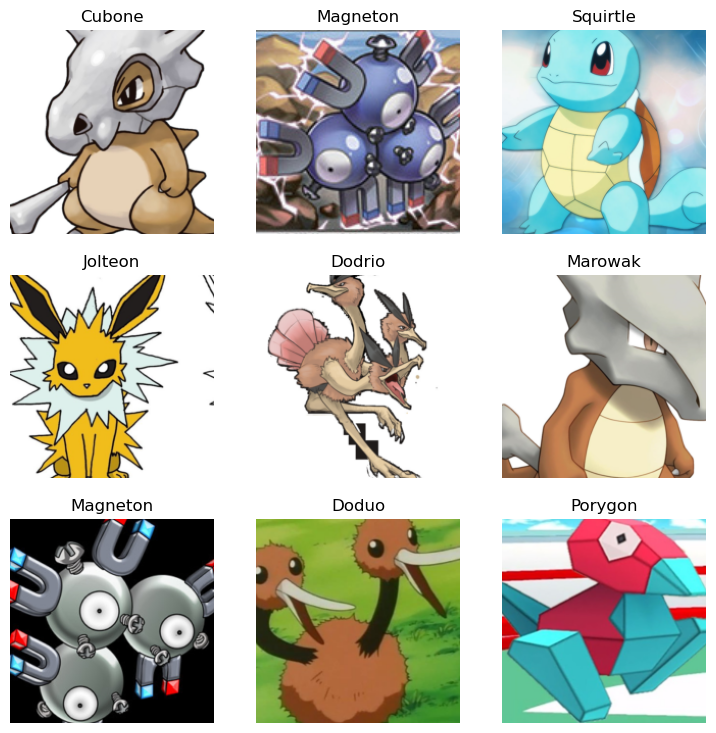

In [9]:
dls.valid.show_batch()

## Using Resnet18

In [10]:
learner = vision_learner(dls, resnet18, metrics = error_rate)
learner.fine_tune(10)

epoch,train_loss,valid_loss,error_rate,time
0,5.143427,2.400970,0.545455,00:20


epoch,train_loss,valid_loss,error_rate,time
0,2.945763,1.566038,0.352639,00:16
1,2.136840,0.922161,0.224340,00:15
2,1.542296,0.607549,0.145894,00:15
3,1.116086,0.497638,0.138563,00:16
4,0.867695,0.418835,0.112170,00:18
5,0.731791,0.376985,0.110704,00:17
6,0.610106,0.373021,0.100440,00:18
7,0.548919,0.345120,0.095308,00:17
8,0.495309,0.335707,0.091642,00:19
9,0.470691,0.330348,0.088710,00:18


In [48]:
# Using recorder to get values
train_loss = [item[0] for item in learner.recorder.values]
valid_loss = [item[1] for item in learner.recorder.values]
error_rate = [1 - item[2] for item in learner.recorder.values]
print(train_loss, valid_loss, error_rate, sep = '\n')

[2.945763111114502, 2.1368401050567627, 1.542296051979065, 1.1160858869552612, 0.8676945567131042, 0.731791079044342, 0.610106348991394, 0.5489187240600586, 0.49530893564224243, 0.47069060802459717]
[1.5660382509231567, 0.9221609234809875, 0.6075485348701477, 0.4976375699043274, 0.4188353717327118, 0.37698468565940857, 0.37302127480506897, 0.34512045979499817, 0.3357072174549103, 0.3303478956222534]
[0.6473607122898102, 0.775659829378128, 0.8541055768728256, 0.8614369481801987, 0.887829914689064, 0.8892961889505386, 0.8995601162314415, 0.9046920835971832, 0.9083577692508698, 0.9112903252243996]


After 10 iterations of fine tuning we can see that model has flatten its learning rate in the ending iterations
## Let's try to find a good learning rate
And see if our performance improves by using it?

0.005248074419796467


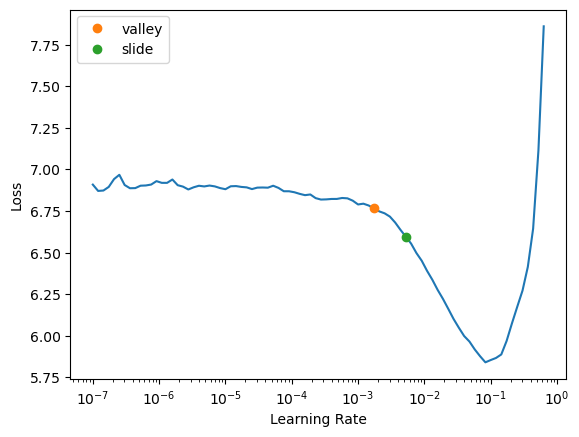

In [23]:
learner2 = vision_learner(dls, resnet18, metrics = error_rate)
l = learner2.lr_find(suggest_funcs=(valley, slide))
print(l.slide)

In [24]:
learner2.fine_tune(5, l.slide)

epoch,train_loss,valid_loss,error_rate,time
0,4.234518,1.613966,0.409091,00:12


epoch,train_loss,valid_loss,error_rate,time
0,1.811546,0.720332,0.195015,00:15
1,1.356451,0.592013,0.170088,00:16
2,0.989715,0.459684,0.139296,00:16
3,0.689691,0.358816,0.103372,00:16
4,0.526024,0.356295,0.098240,00:17


In [49]:
doc(plt)

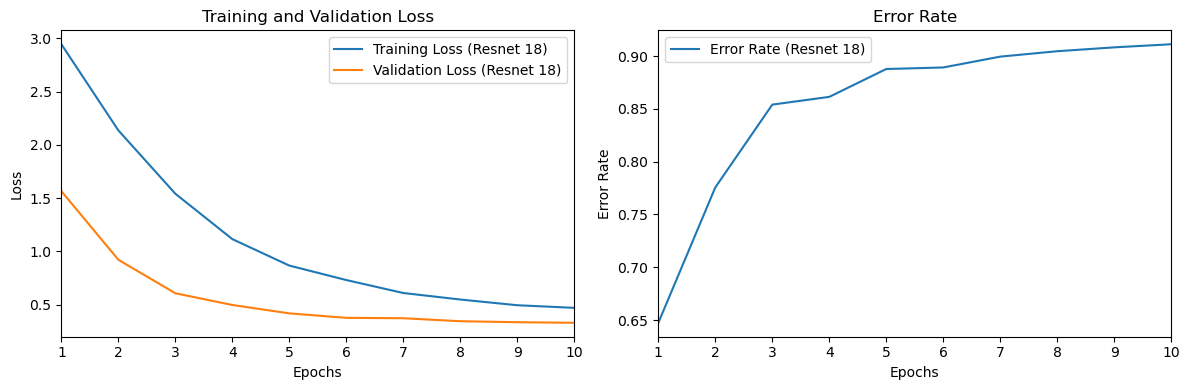

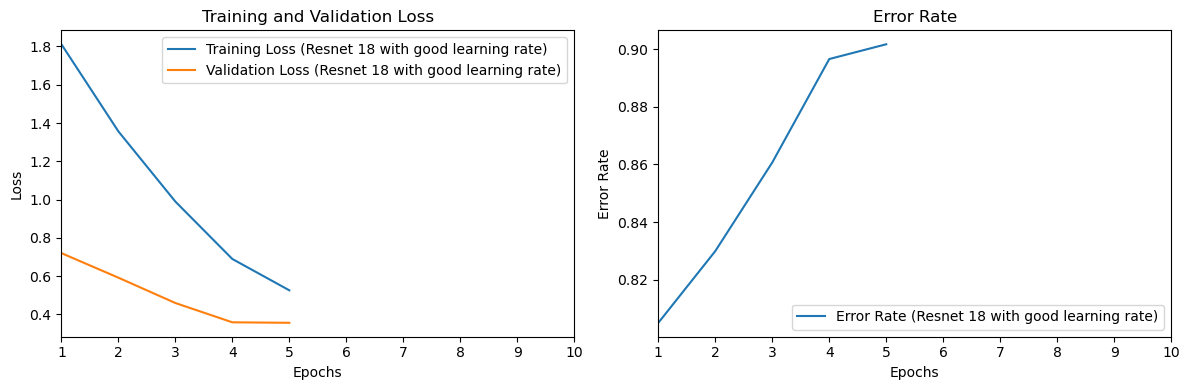

In [59]:
# Plotting training history for both learners
def plot_training_history(learn, label):
    # Extract training loss, validation loss, and error rate from training history
    train_loss = [item[0] for item in learn.recorder.values]
    valid_loss = [item[1] for item in learn.recorder.values]
    error_rate = [1 - item[2] for item in learn.recorder.values]

    # Plotting
    epochs = range(1, len(train_loss) + 1)
    plt.figure(figsize=(12, 4))

    # Plotting training and validation loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss, label=f'Training Loss ({label})')
    plt.plot(epochs, valid_loss, label=f'Validation Loss ({label})')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.xlim(1, 10)
    plt.legend()

    # Plotting error rate
    plt.subplot(1, 2, 2)
    plt.plot(epochs, error_rate[:10], label=f'Error Rate ({label})')
    plt.xlabel('Epochs')
    plt.ylabel('Error Rate')
    plt.title('Error Rate')
    plt.xlim(1, 10)
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plotting training history for learner1
plot_training_history(learner, 'Resnet 18')

# Plotting training history for learner2
plot_training_history(learner2, 'Resnet 18 with good learning rate')


We got similar accurate model when we used a good learning rate in nearly half iterations.
## Checking prediction

In [78]:
TestInput = Path('.').cwd()/'TestInputs'
categories = learner.dls.vocab

In [108]:
def predict(img):
    pred, idx, probs = learner2.predict(img)
    idx = dict(zip(categories, map(float, probs)))
    return pred, idx[pred]

In [112]:
img = TestInput/'04.png'
predict(img)

('Clefable', 0.5200459957122803)

In [113]:
learner2.export(fname = 'resnet18_glr_pokemon.pkl')